In [1]:
from math import sin, cos, sqrt
import numpy as np
from scipy.optimize import fsolve
from numpy.linalg import norm

import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
def func(p):
    x, y = p
    return (sin(x+1) - y - 1.2, 
            2*x + cos(y) - 2)

## 1. Постановка задачи

Найти решение данной нелинейной системы
$$
\large
\begin{cases}
   sin(x+1) - y - 1.2 = 0\\
   2x + cos(y) - 2 = 0
 \end{cases}
$$

Для наглядности визуализируем функционал $z(x, y) = (sin(x+1)-y-1.2)^2+(2x+cos(y)-2)^2$ на 3d-плоскости:

In [3]:
init_notebook_mode(connected=True)

x = np.linspace(-15, 14, 100)
y = np.linspace(-15, 14, 100)
Y, X = np.meshgrid(x, y)

Z = (np.sin(X+1) - Y - 1.2)**2 + (2*X+np.cos(Y)-2)**2

trace = go.Surface(z=Z, x=X, y=Y, colorscale='Jet')
iplot([trace])

Получим истинное решение, с которым будем далее сравнивать наши

In [4]:
x, y =  fsolve(func, (1, 1))
x_true = (x, y)
print(func((x, y)))

(5.1403326040144748e-13, 1.1377565556358604e-12)


In [5]:
print('Solution: ', 'x =', round(x, 5), 'y =', round(y, 5))

Solution:  x = 0.51015 y = -0.20184


Теперь используем для решения данной системы методы из нашего курса (метод последовательных итераций и метод Ньютона)

## 2. Метод простой итерации

Сведем систему к виду $u = f(u)$:

\begin{cases}
x = -cos(y)/2 + 1\\
y = sin(x+1) - 1.2
\end{cases}

Построим итерационный процесс следующего вида: $u^{n+1} = f(u^n)$,
где $f(x, y) = \begin{pmatrix}
-cos(y)/2 + 1\\
sin(x+1) - 1.2
\end{pmatrix}$

Исследуем его на сходимость

$\|f(u_1) - f(u_2)\|_3 = \sqrt{(cos(y_1)/2-cos(y_2)/2)^2+(sin(x_1+1)-sin(x_2+1))^2} \le \sqrt{5} \le q \cdot \sqrt{(y_1-y_2)^2+(x_1-x_2)^2} = q \, \|u_1 - u_2\|_3$

Положим $q=\frac{1}{\sqrt{2}}$, при этом на области $\Omega_1 = [-1,1] \times [-1,1]$ - метод будет гарантированно сходиться со скоростью, заданной слудующей формулой:  $\|u^n - u^* \|_3 \le \frac{q^n \|u_1-u_0\|_3}{1-q}$

Заметим, что при расширении области, максимум выражения $\|u_1 - u_2\|_3$ будет только увеличиваться, при этом $q$ также будет только уменьшаться, оставаясь $\le 1$. Получаем, что область сходимости метода простой итерации: $\Omega = \mathbb{R}^2$.

In [6]:
def f(p):
    x, y = p
    return (-cos(y)/2 + 1,
            sin(x+1) - 1.2)

In [7]:
def iteration_method(u0, eps, verbose=True):
    x, y = u0
    step1 = norm(np.array(f([x,y])) - [x,y])
    n = 0
    q = 1 / sqrt(2)
    while not q**n * step1 / (1-q) < eps:
        x, y = f([x, y])
        n += 1
    if verbose:
        print('Метод сошелся за {} итераций'.format(n))
    return [x, y]

In [8]:
res = iteration_method((0, 1), 1e-3, verbose=True)
print("Результат: {}".format((round(res[0], 5), round(res[1], 5))))
print("Отклонение от истинного результата в евкл. норме: {}".format(norm(np.array(res) - np.array(x_true))))
print("Невязка: {}".format(func(res)))

Метод сошелся за 25 итераций
Результат: (0.51015, -0.20184)
Отклонение от истинного результата в евкл. норме: 7.794696081024074e-13
Невязка: (0.0, 0.0)


## 3. Метод Ньютона

$$\begin{cases}
x + cos(y)/2 - 1\\
y - sin(x+1) + 1.2
\end{cases}$$
$u^{n+1} = u^n - J^{-1} F(u^n)$ - итерационный процесс,

где $F(x, y) = \begin{pmatrix}
x + cos(y)/2 - 1\\
y - sin(x+1) + 1.2
\end{pmatrix}$ и
$J = \begin{pmatrix}
1 & -sin(y)/2 \\
-cos(x+1) & 1
\end{pmatrix}$

Заметим также, что
$$J^{-1} = \frac{1}{1-sin(y)cos(x+1)/2}
\begin{pmatrix}
 1 & sin(y)/2 \\
 cos(x+1) & 1
\end{pmatrix}$$

In [9]:
def inv_J(p):
    x, y = p
    return np.dot([[1, sin(y)/2], [cos(x+1), 1]], (1 / (1 - sin(y)*cos(x+1)/2)))

In [10]:
def F(p):
    x, y = p
    return (x + cos(y)/2 - 1,
            y - sin(x+1) + 1.2)

In [11]:
def Newton_method(p, num_iter):
    x, y = p
    for _ in range(num_iter):
        x, y = x - np.dot(inv_J([x,y]), F([x,y]))[0], y - np.dot(inv_J([x,y]), F([x,y]))[1]
    return (x, y)

In [12]:
res = Newton_method([0, 0], 5)
print("Результат: {}".format((round(res[0], 5), round(res[1], 5))))
print("Ошибка в евк. норме: {}".format(norm(np.array(res) - np.array(x_true))))
print("Невязка метода: {}".format(func(res)))

Результат: (0.51014999999999999, -0.20183999999999999)
Ошибка в евк. норме: 7.795065415551751e-13
Невязка метода: (0.0, 0.0)


Проанализируем область сходимости

In [13]:
N = 100
dim = 201
X = np.linspace(-N, N, dim)
Y = np.linspace(-N, N, dim)

converge_matrix = np.ones((dim, dim)) * -1

for i, x in enumerate(X):
    for j, y in enumerate(Y):
        x, y = Newton_method([x, y], 10)
        if norm(np.array([x, y]) - np.array(x_true)) < 0.001:
            converge_matrix[i][j] = 1

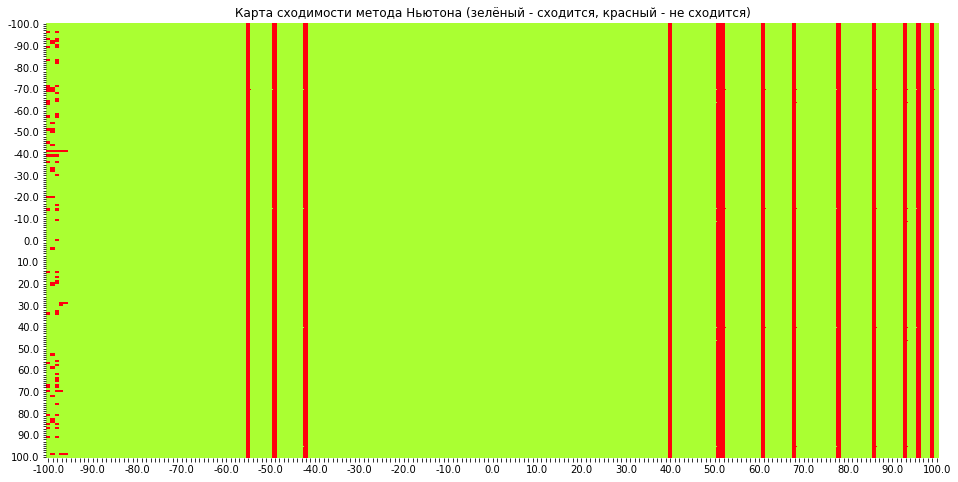

In [14]:
import seaborn as sns

plt.figure(figsize=(16, 8))
colors = ['bright red', 'lime']
xlims = list(map(lambda x: x if list(X).index(x) % 10 == 0 else '', X))
ylims = list(map(lambda y: y if list(Y).index(y) % 10 == 0 else '', Y))
plt.title('Карта сходимости метода Ньютона (зелёный - сходится, красный - не сходится)')
sns.heatmap(converge_matrix, xticklabels=xlims, yticklabels=ylims, cmap=sns.xkcd_palette(colors), cbar=False);

Область сходимости имеет сложный характер.

## 4. Выводы

Как метод простой итерации, так и метод Ньютона успешно решили задачу.

При этом следует отметить, что метод Ньютона потребовал в 5 раз меньше итераций.